In [ ]:
#learninmg rate decay rate 0.01 500 step 
decay_steps=100
deacy_rate=0.001
#learning rate 
#lr=0.001
learning_rate=0.001

In [ ]:
import math, random
#import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
#?

In [ ]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

# env

In [ ]:
import pickle
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/Projects /rl_pro'

/content/gdrive/My Drive/Projects /rl_pro


In [ ]:
class sim_env:
  '''
  total frames 980 
  980/4=245 frames 
  why dont u try frame skip only 4 frames per second 
  so 32 second / 32 step game 
  30 frames => you wanna select 4 => frame 1 , frame 10 , frame 20 , frame 30 
  skip 10 frames 
  so 24 steps 
  1+40*24=961
  if num>950 then done 
  '''
  def __init__(self,bouding_box_list):
        self.iou_sacle_factor=50;
        self.frame_skip_step=10
        #self.video_file_path = video_file_path
        self.bouding_box_list = bouding_box_list
        self.frame_num=0
        #initial coord of car 
        self.x1=580
        self.x2=717
        self.y2=700
        self.y1=600
        self.step_size=20
        #how many pixel car moves if action L or R is taken 
        #height and width of input video file image 
        self.height=720
        self.width=1280
        self.classes_to_consider=['Car','Person','Land vehicle','Vehicle','Van','Truck']
        with open(bouding_box_list, "rb") as fp:
          self.box_file=pickle.load(fp)
  def reset(self):
    self.frame_num=0
    self.x1=580
    self.x2=717
    self.y2=700
    self.y1=600
    return self.return_frame_stack(self.frame_num)

  def return_frame_stack(self,num):
    frame1=self.return_frame(num)
    frame2=self.return_frame(num+self.frame_skip_step)
    frame3=self.return_frame(num+2*self.frame_skip_step)
    frame4=self.return_frame(num+3*self.frame_skip_step)
    frame_stack=np.stack((frame1,frame2,frame3,frame4),axis=0)

    #state=torch.from_numpy(frame_stack)
    #state=state.unsqueeze(0)
    #state=state.float()
    #return state
    return frame_stack

  def return_total_iou(self,num):
    iou1=self.return_iou(num)
    iou2=self.return_iou(num+self.frame_skip_step)
    iou3=self.return_iou(num+2*self.frame_skip_step)
    iou4=self.return_iou(num+3*self.frame_skip_step)
    iou_total=iou1+iou2+iou3+iou4
    return iou_total

  def return_frame(self,num):
    '''
    make a blank image of correct dimension height and width
    read file and get coord of cars 
    fill the blank image with bouding boxes of cars 
    retun the image   
    '''
    height=self.height
    width=self.width
    result_of_object_det=self.box_file[num]
    boxes=result_of_object_det["detection_boxes"]
    class_names=result_of_object_det["detection_class_entities"]
    scores=result_of_object_det["detection_scores"]
    num_of_detetected_objects=boxes.shape[0]
    blank_img=np.zeros(shape=[height,width], dtype=np.uint8)
    #draw_our_car
    blank_img=cv2.rectangle(blank_img,(self.x1,self.y1),(self.x2,self.y2),(255,0,0),-1)
    
    #total_iou=0
    for i in range (0,num_of_detetected_objects):
      det_score=scores[i].numpy()
      threshold=0.1
      if(det_score>threshold):
            class_name=class_names[i].numpy()
            class_name=str(class_name, 'UTF-8')
            if class_name in self.classes_to_consider:
                    box=boxes[i].numpy()
                    ymin=int(box[0]*height)
                    xmin=int(box[1]*width)
                    ymax=int(box[2]*height)
                    xmax=int(box[3]*width)
                    blank_img=cv2.rectangle(blank_img,(xmin,ymin),(xmax,ymax),(255,0,0),-1)
                    #iou cal 
                    #iou_of_curr_box=self.get_iou([xmin,ymin,xmax,ymax])
                    #total_iou=total_iou + self.iou_sacle_factor*iou_of_curr_box
    return blank_img

  def return_iou(self,num):
      '''
      make a blank image of correct dimension height and width
      read file and get coord of cars 
      fill the blank image with bouding boxes of cars 
      retun the image   
      '''
      height=self.height
      width=self.width
      result_of_object_det=self.box_file[num]
      boxes=result_of_object_det["detection_boxes"]
      class_names=result_of_object_det["detection_class_entities"]
      scores=result_of_object_det["detection_scores"]
      num_of_detetected_objects=boxes.shape[0]
      #blank_img=np.zeros(shape=[height,width], dtype=np.uint8)
      #draw_our_car
      #blank_img=cv2.rectangle(blank_img,(self.x1,self.y1),(self.x2,self.y2),(255,0,0),-1)
      total_iou=0
      for i in range (0,num_of_detetected_objects):
        det_score=scores[i].numpy()
        threshold=0.1
        if(det_score>threshold):
              class_name=class_names[i].numpy()
              class_name=str(class_name, 'UTF-8')
              if class_name in self.classes_to_consider:
                      box=boxes[i].numpy()
                      ymin=int(box[0]*height)
                      xmin=int(box[1]*width)
                      ymax=int(box[2]*height)
                      xmax=int(box[3]*width)
                      #blank_img=cv2.rectangle(blank_img,(xmin,ymin),(xmax,ymax),(255,0,0),-1)
                      #iou cal 
                      iou_of_curr_box=self.get_iou([xmin,ymin,xmax,ymax])
                      total_iou=total_iou + self.iou_sacle_factor*iou_of_curr_box
      return total_iou

  def act(self,action_num):
    '''
    0=> move Left self.step_size=20 
    1=> no acton remain in position 
    2=> Right self.step_size=20
    '''
    if action_num==0:
      self.x1=self.x1-20
      self.x2=self.x2-20
    elif action_num==2:
      self.x1=self.x1+20
      self.x2=self.x2+20

  def step(self,action_num):
    '''
    take action
    cal iou for prev frame stack 
    return next frame stack
    
    '''
    #frame_num
    #return next_state,reward,done
    #def get_orginal_frame(self,frame_num):
    
    '''
    1 executre action
    2 calculate reward
    3 update frame num 
    4 check done or not 
    5 fetch next set of frames 
    '''
    done=0
    self.act(action_num) #executre action
    total_iou=self.return_total_iou(self.frame_num) #calculate reward
    reward=-1*total_iou

    self.frame_num=self.frame_num+40 #update frame num

    next_set_frame_num=self.frame_num+40#check done or not 
    next_state=None
    if(next_set_frame_num>980):
      done=1
      next_state= self.return_frame_stack(0)#just for the reply buffer wont be used during training coz (1-done)*next_state_q_values 
    else :
      next_state= self.return_frame_stack(self.frame_num)#fetch next frame stack 
    return next_state,reward,done


  def get_iou(self,box):
      bb1={}
      bb2={}
      bb1['x1']=self.x1
      bb1['y1']=self.y1
      bb1['x2']=self.x2
      bb1['y2']=self.y2

      bb2['x1']=box[0]
      bb2['y1']=box[1]
      bb2['x2']=box[2]
      bb2['y2']=box[3]
      #print(bb2)
      assert bb1['x1'] < bb1['x2']
      assert bb1['y1'] < bb1['y2']
      assert bb2['x1'] < bb2['x2']
      assert bb2['y1'] < bb2['y2']

      x_left = max(bb1['x1'], bb2['x1'])
      y_top = max(bb1['y1'], bb2['y1'])
      x_right = min(bb1['x2'], bb2['x2'])
      y_bottom = min(bb1['y2'], bb2['y2'])

      if x_right < x_left or y_bottom < y_top:
          return 0.0
    
      # The intersection of two axis-aligned bounding boxes is always an
      # axis-aligned bounding box
      intersection_area = (x_right - x_left) * (y_bottom - y_top)
      # compute the area of both AABBs
      bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
      bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

      # compute the intersection over union by taking the intersection
      # area and dividing it by the sum of prediction + ground-truth
      # areas - the interesection area
      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
      assert iou >= 0.0
      assert iou <= 1.0
      return iou

In [ ]:
import random
env=sim_env("obj_det_result_t3.txt")

In [ ]:
#env_id = "CartPole-v0"
#env = gym.make(env_id)


# training

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

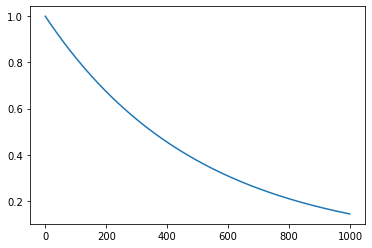

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(1000)])

In [ ]:
class DQN(nn.Module):
    def __init__(self,num_ch, num_actions):
        super(DQN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d( num_ch,8, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d( 8,16, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.block2= nn.Sequential(
            nn.Linear(55616, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
            )
        
    def forward(self, x):
        x=self.block1(x)
        x = x.view(x.size(0), -1)#flatten
        x=self.block2(x)
        return x
        
    
    def act(self, state, epsilon):
        #print("ACTTT ")
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
            action=action.item()

            #print("state=:",state,"q_value=",q_value,"action=",action)

            #print("action from above")
        else:
            action = random.randrange(3)
            #print("action from below")
        return action

# conv test 

In [ ]:
block1 = nn.Sequential(
            nn.Conv2d( 4,8, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d( 8,16, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

In [ ]:
x=np.zeros(shape=[4,720,1280])

In [ ]:
y = torch.from_numpy(x)

In [ ]:
y.shape

torch.Size([4, 720, 1280])

In [ ]:
y = y.unsqueeze(0)

In [ ]:
#conv2d expects(n_samples, channels, height, width)

In [ ]:
y_f=y.float()

In [ ]:
y_f.dtype

torch.float32

In [ ]:
z=block1(y_f)

In [ ]:
z.shape

torch.Size([1, 16, 44, 79])

In [ ]:
zx = z.view(z.size(0), -1)

In [ ]:
zx.shape

torch.Size([1, 55616])

# New Section

In [ ]:


model = DQN(4,3)
if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=deacy_rate)
replay_buffer = ReplayBuffer(1000)

In [ ]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    return loss

In [ ]:

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [ ]:
#state=env.reset()

In [ ]:
#print(state.shape)

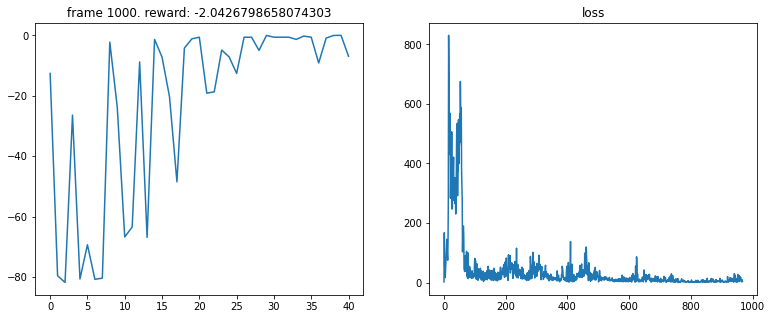

In [ ]:
num_frames = 1000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    #state=torch.from_numpy(state)
    #state=state.unsqueeze(0)
    #state=state.float()

    #print(state.shape)
    #print(done)
    #print(state.shape)
    
    action = model.act(state, epsilon)
    #print(action)
    next_state, reward, done = env.step(action)
    #print(next_state.shape)
    replay_buffer.push(state.squeeze(), action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        #print(loss.item())
        #losses.append(loss.data[0])
        losses.append(loss.item())
        
    if frame_idx % 10 == 0:
        plot(frame_idx, all_rewards, losses)

In [ ]:
'''
saving model
torch.save(model.state_dict(), PATH)
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''

In [ ]:
ls

'download (3).png'   model_param   obj_det_result_t3.txt   t3.mp4


In [ ]:
torch.save(model.state_dict(),"model_param")

In [ ]:
model_s = DQN(4,3)

In [ ]:
model_s.load_state_dict(torch.load("model_param"))
model_s.eval()

DQN(
  (block1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=55616, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

# run env for 10 times with trained model 

In [ ]:
state=env.reset()
r=0
reward_list=[]
i=0
while(1):

  action = model.act(state, epsilon)
  #print(action)
  next_state, reward, done = env.step(action)
  state=next_state
  r=reward+r
  if done==1:
    state=env.reset()
    reward_list.append(r)
    print("i=",i,"r=",r)
    r=0
    i=i+1

  if i>10:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


i= 0 r= 0.0
i= 1 r= -0.02926469575409644
i= 2 r= -4.9818406117809335
i= 3 r= 0.0
i= 4 r= 0.0
i= 5 r= 0.0
i= 6 r= 0.0
i= 7 r= 0.0
i= 8 r= 0.0
i= 9 r= -8.507203883245934
i= 10 r= 0.0


# Run env 10 times with random action 

In [ ]:
import random

In [ ]:
state=env.reset()
r=0
reward_list=[]
i=0
action_list = [0,1,2]


while(1):
  action=random.choice(action_list)
  #print(action)
  next_state, reward, done = env.step(action)
  state=next_state
  r=reward+r
  if done==1:
    state=env.reset()
    reward_list.append(r)
    print("i=",i,"r=",r)
    r=0
    i=i+1

  if i>10:
    break

i= 0 r= -80.1643980965203
i= 1 r= -69.8046546797671
i= 2 r= -71.43254838830487
i= 3 r= -74.52974781325412
i= 4 r= -80.6649352953337
i= 5 r= -81.67242148557844
i= 6 r= -58.39933610230575
i= 7 r= -16.229273652821345
i= 8 r= -61.4681258333171
i= 9 r= -26.511832364045084
i= 10 r= -69.64736309232293
